## Step 0: Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


In [2]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Horizon + lookback must match preprocessing filenames
H = 3
LOOKBACK = 14

In [3]:
# Paths
DATA_PROCESSED_DIR = "data/processed"
OUT_PRED_DIR = "outputs/predictions"
OUT_FIG_DIR = "outputs/figures"

os.makedirs(OUT_PRED_DIR, exist_ok=True)
os.makedirs(OUT_FIG_DIR, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## Step 1: Load the saved CNN sequences 

We load the `.npz` file created in preprocessing (train/val/test sequences) and the meta CSVs with `(ticker_id, date)`.


In [5]:
# Load sequences 
seq_path = os.path.join(DATA_PROCESSED_DIR, f"cnn_sequences_H{H}_L{LOOKBACK}.npz")
data = np.load(seq_path)

X_train = data["X_train"]  # (N, C, L)
tid_train = data["tid_train"]
y_train = data["y_train"]

X_val = data["X_val"]
tid_val = data["tid_val"]
y_val = data["y_val"]

X_test = data["X_test"]
tid_test = data["tid_test"]
y_test = data["y_test"]

print("Train X:", X_train.shape, "Val X:", X_val.shape, "Test X:", X_test.shape)


Train X: (1136, 8, 14) Val X: (192, 8, 14) Test X: (178, 8, 14)


In [6]:
# Load meta files so we can save predictions with date + ticker_id
meta_train = pd.read_csv(os.path.join(DATA_PROCESSED_DIR, f"cnn_meta_train_H{H}_L{LOOKBACK}.csv"), parse_dates=["date"])
meta_val   = pd.read_csv(os.path.join(DATA_PROCESSED_DIR, f"cnn_meta_val_H{H}_L{LOOKBACK}.csv"), parse_dates=["date"])
meta_test  = pd.read_csv(os.path.join(DATA_PROCESSED_DIR, f"cnn_meta_test_H{H}_L{LOOKBACK}.csv"), parse_dates=["date"])

# quick check: meta length should match X length
assert len(meta_train) == X_train.shape[0]
assert len(meta_val) == X_val.shape[0]
assert len(meta_test) == X_test.shape[0]

# Number of tickers (for embedding)
num_tickers = int(max(tid_train.max(), tid_val.max(), tid_test.max()) + 1)
print("Num tickers:", num_tickers)

Num tickers: 6


## Step 2: Dataset + DataLoaders

We wrap our arrays into a Dataset that returns `(sequence, ticker_id, label)`, then create DataLoaders.

In [7]:
class CNNDataset(Dataset):
    """
    Each item:
      x   -> (C, L) sequence (already scaled in preprocessing)
      tid -> scalar ticker_id
      y   -> scalar label (0/1)
    """
    def __init__(self, X, tid, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.tid = torch.tensor(tid, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.tid[idx], self.y[idx]

train_ds = CNNDataset(X_train, tid_train, y_train)
val_ds   = CNNDataset(X_val, tid_val, y_val)
test_ds  = CNNDataset(X_test, tid_test, y_test)

In [8]:
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# quick sanity check
xb, tidb, yb = next(iter(train_loader))
print("Batch x:", xb.shape)      # (batch, C, L)
print("Batch tid:", tidb.shape)  # (batch,)
print("Batch y:", yb.shape)      # (batch,)

Batch x: torch.Size([64, 8, 14])
Batch tid: torch.Size([64])
Batch y: torch.Size([64])


## Step 3: Define the CNN and ticker embedding model

We apply 1D convolutions over time (the lookback window), then concatenate a ticker embedding, and finish with a small MLP head.
The CNN can learn short-term patterns in the sequence (trends/spikes), while the embedding lets one shared model adapt per asset.


In [11]:
class CNNWithTickerEmbedding(nn.Module):
    def __init__(self, num_features, num_tickers, lookback,
                 emb_dim=8, num_filters=32, kernel_size=3, hidden_size=64, dropout=0.1):
        super().__init__()

        # Learned vector per ticker_id
        self.emb = nn.Embedding(num_tickers, emb_dim)

        # Conv1D over time (input is (batch, C, L))
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=num_filters,
                               kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters,
                               kernel_size=kernel_size, padding=kernel_size // 2)

        self.pool = nn.MaxPool1d(kernel_size=2)
        self.drop = nn.Dropout(dropout)

        # compute pooled length after 2 pools
        pooled_len = lookback
        pooled_len = pooled_len // 2
        pooled_len = pooled_len // 2
        pooled_len = max(1, pooled_len)

        conv_out_dim = num_filters * pooled_len

        # classifier head: conv features + embedding
        self.fc1 = nn.Linear(conv_out_dim + emb_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x, ticker_id):
        # x: (batch, C, L)
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.flatten(start_dim=1)     # (batch, conv_out_dim)

        e = self.emb(ticker_id)        # (batch, emb_dim)
        z = torch.cat([x, e], dim=1)   # (batch, conv_out_dim + emb_dim)

        z = F.relu(self.fc1(z))
        z = self.drop(z)
        logits = self.fc2(z)
        return logits


In [12]:
# Instantiate
num_features = X_train.shape[1]  # C
model = CNNWithTickerEmbedding(
    num_features=num_features,
    num_tickers=num_tickers,
    lookback=LOOKBACK,
    emb_dim=8,
    num_filters=32,
    kernel_size=3,
    hidden_size=64,
    dropout=0.1
).to(device)

print(model)

CNNWithTickerEmbedding(
  (emb): Embedding(6, 8)
  (conv1): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=104, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [13]:
# quick forward sanity check
xb, tidb, yb = next(iter(train_loader))
xb, tidb = xb.to(device), tidb.to(device)
logits = model(xb, tidb)
print("Logits shape:", logits.shape)  # (batch, 2)

Logits shape: torch.Size([64, 2])


## Step 4: Train the CNN (validate each epoch)

We train with CrossEntropy + Adam, track train/val accuracy, and keep the best checkpoint.

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_one_epoch(model, loader, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    total_correct = 0
    total_count = 0

    for xb, tidb, yb in loader:
        xb = xb.to(device)
        tidb = tidb.to(device)
        yb = yb.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(xb, tidb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == yb).sum().item()
        total_count += xb.size(0)

    return total_loss / total_count, total_correct / total_count


In [16]:
EPOCHS = 15
best_val_acc = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, train=True)
    val_loss, val_acc     = run_one_epoch(model, val_loader, train=False)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}


Epoch 01 | train loss 0.6959 acc 0.486 | val loss 0.6905 acc 0.568
Epoch 02 | train loss 0.6874 acc 0.548 | val loss 0.6930 acc 0.568
Epoch 03 | train loss 0.6796 acc 0.592 | val loss 0.6917 acc 0.531
Epoch 04 | train loss 0.6673 acc 0.627 | val loss 0.6830 acc 0.599
Epoch 05 | train loss 0.6503 acc 0.629 | val loss 0.6946 acc 0.510
Epoch 06 | train loss 0.6330 acc 0.648 | val loss 0.6862 acc 0.599
Epoch 07 | train loss 0.6044 acc 0.683 | val loss 0.7439 acc 0.479
Epoch 08 | train loss 0.5881 acc 0.698 | val loss 0.7292 acc 0.547
Epoch 09 | train loss 0.5397 acc 0.748 | val loss 0.7335 acc 0.562
Epoch 10 | train loss 0.4935 acc 0.771 | val loss 0.7626 acc 0.547
Epoch 11 | train loss 0.4662 acc 0.804 | val loss 0.7986 acc 0.562
Epoch 12 | train loss 0.4219 acc 0.827 | val loss 0.9177 acc 0.484
Epoch 13 | train loss 0.3816 acc 0.847 | val loss 0.9232 acc 0.526
Epoch 14 | train loss 0.3430 acc 0.869 | val loss 0.9418 acc 0.542
Epoch 15 | train loss 0.3326 acc 0.865 | val loss 0.9904 acc 0

In [17]:
# restore best model
if best_state is not None:
    model.load_state_dict(best_state)

print("Best val acc:", round(best_val_acc, 3))

Best val acc: 0.599


The training accuracy keeps increasing a lot (it goes up to ~0.86), while the validation accuracy goes up and down and the validation loss starts increasing after some epochs. That’s a classic sign of **overfitting**: the CNN is learning the training set very well, but it doesn’t generalise perfectly to new days.

That’s why we keep the **best checkpoint based on validation accuracy**. Here the best validation accuracy is **0.599** (around epochs 4 or 6). So we restore the weights from that best epoch before moving to the test evaluation.


## Step 5: Test evaluation + save predictions + save plots

We evaluate the best CNN on the test set, plot confusion matrix + ROC curve, and save a predictions CSV.


In [18]:
model.eval()

all_y = []
all_pred = []
all_proba_up = []

with torch.no_grad():
    for xb, tidb, yb in test_loader:
        xb = xb.to(device)
        tidb = tidb.to(device)

        logits = model(xb, tidb)
        probs_up = torch.softmax(logits, dim=1)[:, 1]
        pred = torch.argmax(logits, dim=1)

        all_y.append(yb.numpy())
        all_pred.append(pred.cpu().numpy())
        all_proba_up.append(probs_up.cpu().numpy())

y_true = np.concatenate(all_y)
y_pred = np.concatenate(all_pred)
proba_up = np.concatenate(all_proba_up)

In [19]:
# Accuracy
test_acc = accuracy_score(y_true, y_pred)
print("Test accuracy:", round(float(test_acc), 3))

Test accuracy: 0.528


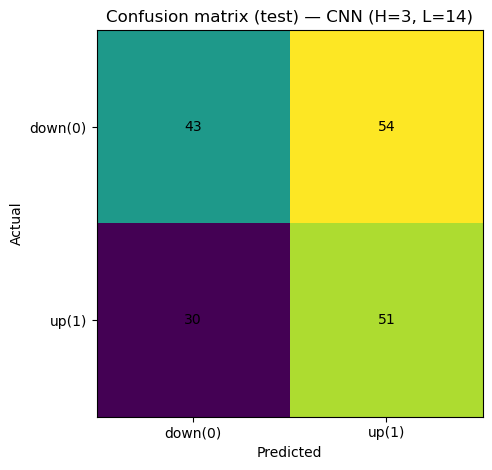

Saved: outputs/figures/cnn_confusion_H3_L14.png


In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title(f"Confusion matrix (test) — CNN (H={H}, L={LOOKBACK})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["down(0)", "up(1)"])
plt.yticks([0, 1], ["down(0)", "up(1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()

cm_path = os.path.join(OUT_FIG_DIR, f"cnn_confusion_H{H}_L{LOOKBACK}.png")
plt.savefig(cm_path)
plt.show()
print("Saved:", cm_path)

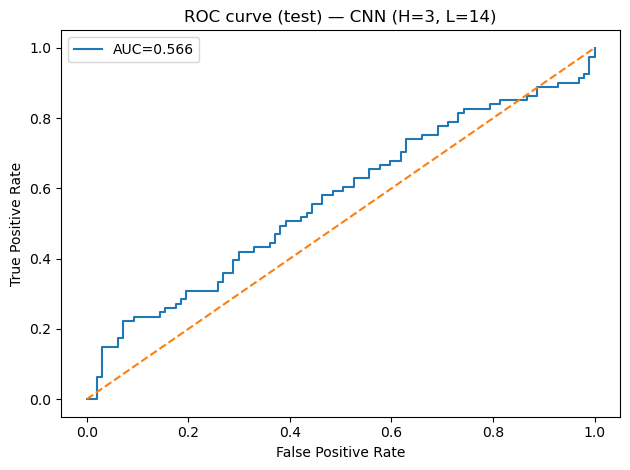

Saved: outputs/figures/cnn_roc_H3_L14.png


In [21]:
# ROC + AUC
auc = roc_auc_score(y_true, proba_up)
fpr, tpr, _ = roc_curve(y_true, proba_up)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC curve (test) — CNN (H={H}, L={LOOKBACK})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()

roc_path = os.path.join(OUT_FIG_DIR, f"cnn_roc_H{H}_L{LOOKBACK}.png")
plt.savefig(roc_path)
plt.show()
print("Saved:", roc_path)

In [22]:
# Save predictions (use meta_test to get date + ticker_id aligned with sequences)
preds = meta_test[["date", "ticker_id"]].copy()
preds["proba_up"] = proba_up
preds["pred_up"] = y_pred
preds["actual_up"] = y_true
preds["correct"] = (preds["pred_up"] == preds["actual_up"]).astype(int)

preds = preds.sort_values(["date", "ticker_id"]).reset_index(drop=True)

out_csv = os.path.join(OUT_PRED_DIR, f"cnn_predictions_H{H}_L{LOOKBACK}.csv")
preds.to_csv(out_csv, index=False)
print("Saved:", out_csv)

preds.head()

Saved: outputs/predictions/cnn_predictions_H3_L14.csv


,date,ticker_id,proba_up,pred_up,actual_up,correct
0,2023-11-18,1,0.638714,1,0,0
1,2023-11-18,2,0.420488,0,1,0
2,2023-11-19,1,0.644862,1,0,0
3,2023-11-19,2,0.401529,0,1,0
4,2023-11-20,1,0.509220,1,1,1
